In [3]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import datetime as dt
from scipy import signal 
import holidays
from analysis import * 
import matplotlib.pyplot as plt 

In [4]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [5]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


In [6]:
def resampling_data(df, feature = 'Load', resample_cost = 'h'):
    f = {'Hour': 'mean', 'Minutes': 'mean', feature: 'sum'}
    tmp = df.copy()
    df_day = tmp.set_index('Date').resample(resample_cost).agg(f)
    df_day.reset_index(drop=False, inplace=True)
    df_day['Day'] = df_day.Date.dt.day_of_week
    poland_holidays = holidays.CountryHoliday('Poland')
    df_day['Holiday'] = df_day.Date.apply(lambda x: x in poland_holidays)
    df_day['Day id'] = df_day.Date.dt.day_of_year
    peaks_up, _  = signal.find_peaks(df_day[feature], distance=5000)
    peaks_down, _  = signal.find_peaks(-df_day[feature], distance=5000)
    peaks = np.concatenate(([0], peaks_down, peaks_up, [len(df_day)-1]))
    df_day.loc[peaks, feature] = np.nan
    df_day[feature].interpolate(inplace=True)

    return df_day

df = resampling_data(Electric)

df = df[~df.Load.isna()].reset_index(drop=True)
df

,Date,Hour,Minutes,Load,Day,Holiday,Day id
0,2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1
1,2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1
2,2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1
3,2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1
4,2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1
...,...,...,...,...,...,...,...
78907,2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366
78908,2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366
78909,2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366
78910,2016-12-31 23:00:00,23.0,22.5,63019.8,5,False,366


In [7]:
m, q = np.polyfit(x=df.index, y=df.Load, deg=1)
load_lin = m * df.index + q

df['Load_lin'] = load_lin
df['Load_detrend'] = df.Load - df['Load_lin']

df

,Date,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin,Load_detrend
0,2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1,68781.328648,-7961.428648
1,2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1,68781.407929,-10911.607929
2,2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1,68781.487211,-13108.687211
3,2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1,68781.566492,-13449.866492
4,2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1,68781.645773,-14254.645773
...,...,...,...,...,...,...,...,...,...
78907,2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366,75037.169791,-4646.869791
78908,2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366,75037.249072,-8112.149072
78909,2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366,75037.328354,-10137.228354
78910,2016-12-31 23:00:00,23.0,22.5,63019.8,5,False,366,75037.407635,-12017.607635


In [26]:
feature='Load_detrend'
cut_day='2016-12-22'

train_set = df[df.Date <= pd.to_datetime(cut_day, format='%Y-%m-%d')]
test_set = df[df.Date > pd.to_datetime(cut_day, format='%Y-%m-%d')]
n_days_ahead = len(test_set.Date.dt.day_of_year.unique())

working_days = train_set[~train_set.Holiday].reset_index(drop=True)
festivities = train_set[train_set.Holiday].reset_index(drop=True)

f = {feature: ['mean', q1, q2], 'Load_lin': ['mean', q1, q2]}
pred_working_days = working_days.groupby(['Day', 'Hour']).agg(f)
pred_festivities = festivities.groupby(['Day id', 'Hour']).agg(f)

forecasting = []
for day in pd.date_range(cut_day, periods=n_days_ahead, freq="d"):
    if any(day.day_of_year == festivities['Day id']):
        forecasting.append(pred_festivities.loc[day.day_of_year][feature].to_numpy())
    else:
        forecasting.append(pred_working_days.loc[day.day_of_week][feature].to_numpy())
        
forecasting = np.concatenate((forecasting))

TypeError: 'Series' object is not callable

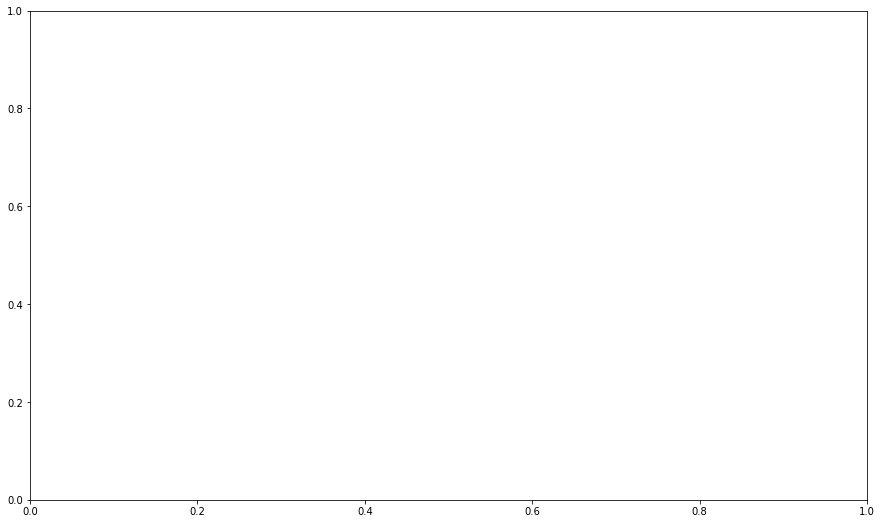

In [62]:
tmp = df[['Date', 'Load_lin', 'Load_detrend']].copy()
n = len(forecasting) - len(test_set)

tmp.loc[tmp.Date > cut_day,
        ['forecast', 'q1_forecast', 'q2_forecast']] = forecasting[:-n, :]

tmp.set_index('Date', inplace=True)
date = pd.to_datetime(cut_day) - dt.timedelta(weeks=4)
date_mask = tmp.index > date


tmp.loc[date_mask, ['Load_detrend', 'forecast']].plot(figsize=(15, 9), grid=True, color='orange')
plt.fill_between(x=tmp[date_mask].index, y1=tmp[date_mask].q1_forecast,
                 y2=tmp[date_mask].q2_forecast, color='orange', alpha=0.5)

#tmp.loc[date_mask, ['Date', 'q1_forecast', 'q1_forecast']].plot()

In [60]:
tmp

,Load_lin,Load_detrend,forecast,q1_forecast,q2_forecast,class
Date,,,,,,
2008-01-01 01:00:00,68781.328648,-7961.428648,NaN,NaN,NaN,0
2008-01-01 02:00:00,68781.407929,-10911.607929,NaN,NaN,NaN,0
2008-01-01 03:00:00,68781.487211,-13108.687211,NaN,NaN,NaN,0
2008-01-01 04:00:00,68781.566492,-13449.866492,NaN,NaN,NaN,0
2008-01-01 05:00:00,68781.645773,-14254.645773,NaN,NaN,NaN,0
...,...,...,...,...,...,...
2016-12-31 20:00:00,1.000000,1.000000,1.0,1.0,1.0,1
2016-12-31 21:00:00,1.000000,1.000000,1.0,1.0,1.0,1
2016-12-31 22:00:00,1.000000,1.000000,1.0,1.0,1.0,1
